# Analysis of Neural Programmer

In [1]:
import copy
import itertools
import operator
import os
import pickle
import re
import string
import sys
import time
from collections import Counter, defaultdict
from random import shuffle

import autoreload
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from IPython.display import HTML, Image, clear_output, display
from scipy.spatial.distance import cosine

sys.path.append('../neural_programmer')

/scratch/pramodkm/tensorflow_gpu_python3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import notebook_utils
import data_utils
from neural_programmer import evaluate

In [3]:
%reload_ext autoreload
%autoreload 2

## Paths, parameters, etc. 

In [285]:
# Use only one GPU on the multi-GPU machine
os.environ["CUDA_VISIBLE_DEVICES"] = "0-3"

# WikiTableQuestions data
DATA_DIR = '../wtq_data'
PERTURBED_DATA_DIR = '../perturbed_wtq_data'

# Pretrained model
MODEL_FILE = os.path.join('..', 'pretrained_model', 'model_92500')
model_step = int(MODEL_FILE.split('_')[-1])

# Output directory to write attributions
OUT_DIR = '../results'

# Overstability curve file
OVERSTABILITY_CURVE_FILE = os.path.join(OUT_DIR, 'overstability.eps')

### Some utility functions

In [95]:
# Operators whose results builds upon the result of previously applied operators
acts_on_prev_result = {
    'count': True,
    'prev': True,
    'next': True,
    'first': True,
    'last': True,
    'mfe': False,
    'greater': False,
    'lesser': False,
    'geq': False,
    'leq': False,
    'max': True,
    'min': True,
    'select': False,
    'reset': False,
    'print': True
}

# Operators whose result depends on the column it is acting on
relies_on_col = {
    'count': False,
    'prev': False,
    'next': False,
    'first': False,
    'last': False,
    'mfe': True,
    'greater': True,
    'lesser': True,
    'geq': True,
    'leq': True,
    'max': True,
    'min': True,
    'select': True,
    'reset': False,
    'print': True
    
}

def get_program_mask(program):
    """ 
    Returns a mask indicating attributions to which ops/cols are considered significant.
    The conditions for are:
    1) affect answer computation,
    2) are not the same as their table-specific default counterparts
    
    program = [op (default_op), col (default_col)] * 4 
    """
    mask = [False] * (2 * 4)
    for i in range(3, -1, -1):
        op, default_op = program[2*i].split('(')
        op = op.strip()
        default_op = default_op.strip().strip(')')
        mask[2*i] = (op != default_op)
        col, default_col = program[2*i + 1].split('(')
        col = col.strip()
        default_col = default_col.strip().strip(')')
        if relies_on_col[op]:
            mask[2*i+1] = (col != default_col)
        if not acts_on_prev_result[op]:
            break
    return mask

## Load data, build graph and restore pretrained weights

In [210]:
train_data, dev_data, test_data, utility, unprocessed_dev_data = notebook_utils.init_data(DATA_DIR)
num_dev_examples = 2831

('Annotated examples loaded ', 14152)
('Annotated examples loaded ', 4344)
('entry match token: ', 9133, 9133)
('entry match token: ', 9134, 9134)
('# train examples ', 10178)
('# dev examples ', 2546)
('# test examples ', 3913)


In [7]:
tf.reset_default_graph()
sess, graph, params = notebook_utils.build_graph(utility)

forget gate bias
('step: ', 0)
('step: ', 1)
('step: ', 2)
('step: ', 3)
('optimize params ', ['unit', 'word', 'word_match_feature_column_name', 'controller', 'column_controller', 'column_controller_prev', 'controller_prev', 'question_lstm_ix', 'question_lstm_fx', 'question_lstm_cx', 'question_lstm_ox', 'question_lstm_im', 'question_lstm_fm', 'question_lstm_cm', 'question_lstm_om', 'question_lstm_i', 'question_lstm_f', 'question_lstm_c', 'question_lstm_o', 'history_recurrent', 'history_recurrent_bias', 'break_conditional'])
('grads: ', <tf.Tensor 'gradients_40/L2Loss_grad/mul:0' shape=(15, 256) dtype=float64>, 'unit')
('grads: ', <tf.Tensor 'gradients_40/L2Loss_1_grad/mul:0' shape=(10800, 256) dtype=float64>, 'word')
('grads: ', <tf.Tensor 'gradients_40/L2Loss_2_grad/mul:0' shape=(1,) dtype=float64>, 'word_match_feature_column_name')
('grads: ', <tf.Tensor 'gradients_40/L2Loss_3_grad/mul:0' shape=(512, 256) dtype=float64>, 'controller')
('grads: ', <tf.Tensor 'gradients_40/L2Loss_4_gra

In [8]:
sess, graph = notebook_utils.restore_model(sess, graph, params, MODEL_FILE)

INFO:tensorflow:Restoring parameters from ../pretrained_model/model_92500


In [303]:
num_correct, num_examples, correct_dict = evaluate(sess, dev_data, utility.FLAGS.batch_size, graph, model_step)

('dev set accuracy   after ', 92500, ' : ', 0.37195600942655144)
(2546, 2546)
--------


In [304]:
num_correct/float(num_dev_examples) 

0.3345107735782409

## Apply Integrated Gradients (IG) 

In [57]:
# write attributions to this folder
attrs_outdir = os.path.join(OUT_DIR, 'attributions')
if not os.path.isdir(attrs_outdir):
    os.makedirs(attrs_outdir)

# get embedding of dummy token
embeddings = graph.params["word"].eval()
dummy_embedding = embeddings[utility.dummy_token_id, :]

# which data to use?
data = dev_data

# number of sample points for Riemann integral computation
num_points = 2000

# hard coded stuff in the code
question_attention_mask_value = -10000.0

In [ ]:
batch_size = graph.batch_size

for offset in range(0, len(data) - graph.batch_size + 1, graph.batch_size):
    feed_dict = data_utils.generate_feed_dict(data, offset, graph.batch_size, graph)

    # first run inference to get operator and column sequences, and embeddings of question words
    fetches = [graph.final_correct_list, graph.final_operation_softmax,
               graph.final_column_softmax, graph.question_words_embeddings]
    correct_list, operation_softmax, column_softmax, question_words_embeddings = sess.run(
        fetches, feed_dict)

    # compute table-specific default programs for tables in this batch
    feed_copy = feed_dict.copy()
    for t in graph.question_words_embeddings:
        feed_copy[t] = np.concatenate(
            [np.expand_dims(dummy_embedding, 0)]*batch_size, 0)

    # Ideally the following line should be uncommented, but for attributions,
    # we choose to keep this variable fixed. Note that this induces some bias
    # in the attributions as the baseline is no longer an "empty" question, but
    # an empty question where the question length is implicitly encoded in this variable
    # feed_copy[graph.batch_question_attention_mask].fill(question_attention_mask_value)

    feed_copy[graph.batch_exact_match] = np.zeros_like(
        feed_copy[graph.batch_exact_match])
    feed_copy[graph.batch_column_exact_match] = np.zeros_like(
        feed_copy[graph.batch_column_exact_match])

    fetches = [graph.final_operation_softmax, graph.final_column_softmax]

    default_operation_softmax, default_column_softmax = sess.run(
        fetches, feed_copy)

    for batch_id in range(batch_size):
        wiki_example = data[offset+batch_id]

        # get operator indices
        op_indices = np.argmax(operation_softmax[batch_id, :, :], axis=1)
        col_indices = np.argmax(column_softmax[batch_id, :, :], axis=1)

        op_list = notebook_utils.softmax_to_names(
            operation_softmax[batch_id, :, :], utility.operations_set)
        col_list = notebook_utils.softmax_to_names(
            column_softmax[batch_id, :, :], notebook_utils.get_column_names(wiki_example))

        default_op_list = notebook_utils.softmax_to_names(
            default_operation_softmax[batch_id, :, :], utility.operations_set)
        default_col_list = notebook_utils.softmax_to_names(
            default_column_softmax[batch_id, :, :], notebook_utils.get_column_names(wiki_example))

        print([notebook_utils.rename(w) for w in op_list])
        print(col_list)

        # Sample points along the integral path and collect them as one batch
        scaled_feed = feed_dict.copy()
        for key in list(scaled_feed.keys()):
            value = feed_dict[key]
            if key.shape[0] == batch_size:  # this is a hack
                scaled_feed[key] = [value[batch_id] for i in range(batch_size)]
        scaled_feed[graph.op_ids] = op_indices
        scaled_feed[graph.col_ids] = col_indices

        num_examples = batch_size * int(num_points/float(batch_size))
        scale = 1.0/num_examples

        batch_op_attribution = np.zeros(
            [graph.max_passes, graph.question_length+2], dtype=np.float32)
        batch_col_attribution = np.zeros(
            [graph.max_passes, graph.question_length+2], dtype=np.float32)

        attr_op_softmax = []
        attr_col_softmax = []

        actual_num_numeric_cols = len(wiki_example.original_nc_names)
        actual_num_word_cols = len(wiki_example.original_wc_names)

        exact_match = wiki_example.exact_match
        exact_column_match = wiki_example.exact_column_match

        batch_question_embeddings = np.array(question_words_embeddings)[
            :, batch_id, :]  # shape: 62 x 256

        # split up set of points into batch_size'd batches
        for k in range(0, num_examples, batch_size):
            print('k:', k)
            # scale question words to points between dummy_embedding and actual embedding
            qw_jump = [None]*graph.question_length
            for i, t in enumerate(graph.question_words_embeddings):
                qw_jump[i] = scale * \
                    (batch_question_embeddings[i] - dummy_embedding)
                scaled_feed[t] = [dummy_embedding + j*qw_jump[i]
                                  for j in range(k, k+batch_size)]

            # scale batch_exact_match
            scaled_exact_match = []
            scaled_column_exact_match = []

            exact_match_jump = [None]*(graph.num_cols + graph.num_word_cols)
            exact_column_match_jump = [None] * \
                (graph.num_cols + graph.num_word_cols)
            for i in range(graph.num_cols):
                if i < actual_num_numeric_cols:  # do not scale dummy columns
                    scaled_exact_match.append(np.expand_dims(
                        [j*scale*np.array(exact_match[i]) for j in range(k, k+batch_size)], 1))
                    exact_match_jump[i] = scale*np.array(exact_match[i])
                    scaled_column_exact_match.append(np.expand_dims(
                        [j*scale*np.array(exact_column_match[i]) for j in range(k, k+batch_size)], 1))
                    exact_column_match_jump[i] = scale * \
                        np.array(exact_column_match[i])
                else:
                    scaled_exact_match.append(np.expand_dims(
                        [exact_match[i] for j in range(k, k+batch_size)], 1))
                    exact_match_jump[i] = 0
                    scaled_column_exact_match.append(np.expand_dims(
                        [exact_column_match[i] for j in range(k, k+batch_size)], 1))
                    exact_column_match_jump[i] = 0

            for i in range(graph.num_word_cols):
                if i < actual_num_word_cols:  # do not scale dummy column names
                    scaled_exact_match.append(np.expand_dims(
                        [j*scale*np.array(exact_match[graph.num_cols+i]) for j in range(k, k+batch_size)], 1))
                    exact_match_jump[graph.num_cols + i] = scale * \
                        np.array(exact_match[graph.num_cols+i])
                    scaled_column_exact_match.append(np.expand_dims(
                        [j*scale*np.array(exact_column_match[graph.num_cols + i]) for j in range(k, k+batch_size)], 1))
                    exact_column_match_jump[graph.num_cols + i] = scale * \
                        np.array(exact_column_match[graph.num_cols + i])
                else:
                    scaled_exact_match.append(np.expand_dims(
                        [exact_match[graph.num_cols+i] for j in range(k, k+batch_size)], 1))
                    exact_match_jump[graph.num_cols + i] = 0
                    scaled_column_exact_match.append(np.expand_dims(
                        [exact_column_match[graph.num_cols + i] for j in range(k, k+batch_size)], 1))
                    exact_column_match_jump[graph.num_cols + i] = 0

            scaled_feed[graph.batch_exact_match] = np.concatenate(
                scaled_exact_match, 1)  # shape 20 x 40 x 100
            scaled_feed[graph.batch_column_exact_match] = np.concatenate(
                scaled_column_exact_match, 1)  # shape 20 x 40

            # compute gradients
            fetches = [graph.final_operation_softmax, graph.final_column_softmax, graph.operator_gradients,
                       graph.column_gradients]
            temp_op_softmax, temp_col_softmax, operator_gradients, column_gradients = sess.run(
                fetches, scaled_feed)  # operator gradient shape: 4 x 62 x 20 x 256

            attr_op_softmax.append(temp_op_softmax)
            attr_col_softmax.append(temp_col_softmax)

            # compute attributions
            for stage in range(graph.max_passes):
                n = int(len(operator_gradients)/graph.max_passes)
                temp = [np.sum(operator_gradients[n*stage][i]*qw_jump[i], axis=(0, 1))
                        for i in range(graph.question_length)]
                temp += [np.sum([operator_gradients[n*stage+1][0][:, i, :]*exact_match_jump[i]
                                 for i in range(graph.num_cols + graph.num_word_cols)])]
                temp += [np.sum([operator_gradients[n*stage+2][0][:, i]*exact_column_match_jump[i]
                                 for i in range(graph.num_cols + graph.num_word_cols)])]
                batch_op_attribution[stage, :] += temp

            for stage in range(graph.max_passes):
                n = int(len(column_gradients)/graph.max_passes)
                temp = [np.sum(column_gradients[n*stage][i]*qw_jump[i], axis=(0, 1))
                        for i in range(graph.question_length)]
                temp += [np.sum([column_gradients[n*stage+1][0][:, i, :]*exact_match_jump[i]
                                 for i in range(graph.num_cols + graph.num_word_cols)])]
                temp += [np.sum([column_gradients[n*stage+2][0][:, i]*exact_column_match_jump[i]
                                 for i in range(graph.num_cols + graph.num_word_cols)])]
                batch_col_attribution[stage, :] += temp

        # sanity check to make sure the integral summation adds up to function difference
        attr_op_softmax = np.concatenate(attr_op_softmax, axis=0)
        attr_col_softmax = np.concatenate(attr_col_softmax, axis=0)
        for stage in range(graph.max_passes):
            lhs = np.sum(batch_op_attribution[stage, :])
            input_fn_value = operation_softmax[batch_id,
                                               stage, op_indices[stage]]
            baseline_fn_value = attr_op_softmax[0, stage, op_indices[stage]]
            rhs = input_fn_value - baseline_fn_value
            print('OP', stage, ':', 'baseline=', baseline_fn_value, ', input_fn=',
                  input_fn_value, 'check: ', lhs, ' - ', rhs, ' = ', lhs-rhs)
        for stage in range(graph.max_passes):
            lhs = np.sum(batch_col_attribution[stage, :])
            input_fn_value = column_softmax[batch_id,
                                            stage, col_indices[stage]]
            baseline_fn_value = attr_col_softmax[0, stage, col_indices[stage]]
            rhs = input_fn_value - baseline_fn_value
            print('COL', stage, ':', 'baseline=', baseline_fn_value, ', input_fn=',
                  input_fn_value, 'check: ', lhs, ' - ', rhs, ' = ', lhs-rhs)

        op_attributions = [None]*graph.max_passes
        question_begin = np.nonzero(
            wiki_example.question_attention_mask)[0].shape[0]

        attributions_matrix = np.zeros(
            [graph.question_length - question_begin + 2, 2 * graph.max_passes])
        row_labels = []  # question words, tm, cm
        col_labels = []  # operator and column selections
        col_label_softmaxes = []  # softmaxes of the selections

        for ix in range(question_begin, graph.question_length):
            word = utility.reverse_word_ids[wiki_example.question[ix]]
            if word == utility.unk_token:
                word = word + '-' + [str(w) for w in wiki_example.string_question if w !=
                                     wiki_example.question_number and w != wiki_example.question_number_1][ix - question_begin]
            word = notebook_utils.rename(word)
            row_labels.append(word)
        row_labels.extend(['tm', 'cm'])

        for stage in range(graph.max_passes):
            col_labels.append(notebook_utils.rename(
                op_list[stage]) + ' (' + notebook_utils.rename(default_op_list[stage]) + ')')
            col_labels.append(notebook_utils.rename(
                col_list[stage]) + ' (' + notebook_utils.rename(default_col_list[stage]) + ')')

            col_label_softmaxes.append(str(operation_softmax[batch_id, stage, op_indices[stage]]) + ' (' + str(
                default_operation_softmax[batch_id, stage, op_indices[stage]]) + ')')
            col_label_softmaxes.append(str(column_softmax[batch_id, stage, col_indices[stage]]) + ' (' + str(
                default_column_softmax[batch_id, stage, col_indices[stage]]) + ')')

            attributions_matrix[:, 2 * stage] = batch_op_attribution[stage, question_begin:]
            attributions_matrix[:, 2 * stage +
                                1] = batch_col_attribution[stage, question_begin:]

        question_string = ' '.join([notebook_utils.rename(str(w))
                                    for w in wiki_example.string_question])

        # save operator and column selections to file
        with tf.gfile.GFile(os.path.join(attrs_outdir, wiki_example.question_id + '_labels.tsv'), 'w') as outf:
            outf.write(question_string)
            outf.write('\n')
            outf.write(str(correct_list[batch_id] == 1.0))
            outf.write('\n')
            outf.write('\t'.join(row_labels) + '\n')
            outf.write('\t'.join(col_labels) + '\n')
            outf.write('\t'.join(col_label_softmaxes) + '\n')

        # save attributions to file
        np.savetxt(os.path.join(
            attrs_outdir, wiki_example.question_id + '_attrs.txt'), attributions_matrix)


## Create HTML with visualizations

In [365]:
data = dev_data
figs_outdir = os.path.join(OUT_DIR, "heatmaps")
if not os.path.isdir(figs_outdir):
    os.makedirs(figs_outdir)

In [367]:
sns.set(font_scale=1.0)
rc={'axes.labelsize': 11, 'xtick.labelsize': 14, 'ytick.labelsize': 14}
sns.set(rc=rc)
for wiki_example in data[:graph.batch_size*int(len(data)/graph.batch_size)]:
    attributions = np.loadtxt(os.path.join(attrs_outdir, wiki_example.question_id + '_attrs.txt'))
    with tf.gfile.GFile(os.path.join(attrs_outdir, wiki_example.question_id + '_labels.tsv')) as f:
        lines = f.readlines()
        xlabels = ['\n'.join(w.split()) for w in lines[3].strip().split('\t')]
        ylabels = lines[2].strip().split('\t')
    mask = get_program_mask(lines[3].strip().split('\t'))
    mask = np.expand_dims(mask, 0)
    plt.figure(figsize=(len(xlabels),len(ylabels)/2))
    plot_data = attributions/attributions.sum(axis=0)*mask
    with sns.axes_style('white'):
        sns.heatmap(plot_data, cbar=False, xticklabels=xlabels, yticklabels=ylabels, annot=True, fmt='.2f', robust=True)
    plt.tight_layout()
    plt.savefig(os.path.join(figs_outdir, wiki_example.question_id + '.png'))
    plt.close()

In [368]:
with tf.gfile.GFile(os.path.join(OUT_DIR, 'visualizations.html'), 'w') as htmlf:
    html_str = '<head><link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/4.0.0/css/bootstrap.min.css" integrity="sha384-Gn5384xqQ1aoWXA+058RXPxPg6fy4IWvTNh0E263XmFcJlSAwiGgFAW/dAiS6JXm" crossorigin="anonymous"></head>'
    html_str += '<body> <div class="container"> <h3> Visualizations of the attributions for the Neural Programmer network <br> <small> Lighter colors indicate high values <br> Green and red questions indicate whether the network got the answer right (or wrong)</small></h3></div><br>'
    html_str += '<div class="container">'
    for wiki_example in data[:graph.batch_size*int(len(data)/graph.batch_size)]:
        with tf.gfile.GFile(os.path.join(attrs_outdir, wiki_example.question_id + '_labels.tsv')) as f:
                lines = f.readlines()
                html_str += wiki_example.question_id + ' <div class=' + ('"text-success"' if lines[1].strip() == 'True' else '"text-danger"') + '>' + lines[0] + '</div><br>'
                html_str += '<img src="heatmaps/' + wiki_example.question_id + '.png"></img><br><hr><br>'
    
    html_str += '</div></body></html>'
    htmlf.write(html_str)
    print("Visualizations written to",os.path.join(OUT_DIR, 'visualizations.html'))

Visualizations written to ../results/visualizations.html


## Operator triggers

In [124]:
K = 2
operator_triggers = defaultdict(lambda: [])
for wiki_example in data[:graph.batch_size*int(len(data)/graph.batch_size)]:
    with tf.gfile.GFile(os.path.join(attrs_outdir, wiki_example.question_id + '_labels.tsv')) as f:
        f.readline()
        f.readline()
        row_labels = f.readline().strip().split('\t')
        col_labels = f.readline().strip().split('\t')
        
    attrs = np.loadtxt(os.path.join(
            attrs_outdir, wiki_example.question_id + '_attrs.txt'))
    mask = get_program_mask(col_labels)
    for i in range(4):
        if not mask[2*i]:
            continue
        syn = [row_labels[j] for j in np.argpartition(attrs[:, 2*i], -K)[-K:]]
        syn = [utility.unk_token if s.startswith(utility.unk_token) else s for s in syn]
        operator_triggers[col_labels[2*i].split('(')[0].strip()] += syn

In [125]:
K = 10
df_data = [[k, [w for w, _ in Counter(v).most_common(K) if w not in ['tm','cm']]] for k, v in operator_triggers.items()]
df = pd.DataFrame(df_data, columns=['Operator', 'Triggers'])
df

,Operator,Triggers
0,select,"[tm_token, many, how, number, or, total, after, before, only]"
1,prev,"[before, many, than, previous, above, how, at, most]"
2,first,"[tm_token, first, before, after, who, previous, or, peak]"
3,reset,"[many, total, how, number, last, least, the, first, of]"
4,count,"[many, how, number, total, of, difference, between, long, times]"
5,next,"[after, not, many, next, same, tm_token, how, below]"
6,last,"[last, or, after, tm_token, next, the, chart, not]"
7,mfe,"[most, cm_token, same, as, many, tm_token, not, players, how]"
8,min,"[least, the, not, same, did, amount, smallest, as]"
9,max,"[most, largest, tallest, taller, building, highest, has, had]"


In [126]:
df['Operator'] = '\op' + df['Operator']
print(df.to_latex(escape=False, index=False))

\begin{tabular}{ll}
\toprule
  Operator &                                                          Triggers \\
\midrule
 \opselect &     [tm_token, many, how, number, or, total, after, before, only] \\
   \opprev &              [before, many, than, previous, above, how, at, most] \\
  \opfirst &         [tm_token, first, before, after, who, previous, or, peak] \\
  \opreset &           [many, total, how, number, last, least, the, first, of] \\
  \opcount &  [many, how, number, total, of, difference, between, long, times] \\
   \opnext &              [after, not, many, next, same, tm_token, how, below] \\
   \oplast &                [last, or, after, tm_token, next, the, chart, not] \\
    \opmfe &     [most, cm_token, same, as, many, tm_token, not, players, how] \\
    \opmin &                [least, the, not, same, did, amount, smallest, as] \\
    \opmax &     [most, largest, tallest, taller, building, highest, has, had] \\
    \opgeq &     [at, more, least, had, over, number, than, 

## Apply Integrated Gradients on table-specific default programs

In [372]:
# write attributions to this file
attrs_outdir = os.path.join(OUT_DIR, 'attributions_default_programs')
if not os.path.isdir(attrs_outdir):
    os.makedirs(attrs_outdir)

# get embedding of dummy token
embeddings = graph.params["word"].eval()
dummy_embedding = embeddings[utility.dummy_token_id, :]

# which data to use?
data = copy.deepcopy(dev_data)

# number of sample points for Riemann integral computation
num_points = 2000

# hard coded stuff in the code
question_attention_mask_value = -10000.0

In [229]:
# collect all unique tables
unique_tables = {}
for wiki_example in data:
    if not wiki_example.table_key in unique_tables:
        wiki_example.exact_column_match = np.zeros_like(
            wiki_example.exact_column_match).tolist()
        wiki_example.exact_match = np.zeros_like(
            wiki_example.exact_match).tolist()
        wiki_example.question = [
            utility.dummy_token_id] * graph.question_length
        wiki_example.question_attention_mask = (question_attention_mask_value * \
            np.ones_like(wiki_example.question_attention_mask)).tolist()
        unique_tables[wiki_example.table_key] = wiki_example
data = list(unique_tables.values())

In [ ]:
for offset in range(0, len(data) - graph.batch_size + 1, batch_size):

    feed_dict = data_utils.generate_feed_dict(data, offset, batch_size, graph)
    fetches = [graph.final_correct_list, graph.final_operation_softmax,
               graph.final_column_softmax, graph.column_hidden_vectors, graph.word_column_hidden_vectors]
    correct_list, operation_softmax, column_softmax, column_hidden_vectors, word_column_hidden_vectors = sess.run(
        fetches, feed_dict)

    # compute global default program
    feed_copy = feed_dict.copy()
    feed_copy[graph.column_hidden_vectors] = np.zeros(
        graph.column_hidden_vectors.get_shape().as_list())
    feed_copy[graph.word_column_hidden_vectors] = np.zeros(
        graph.word_column_hidden_vectors.get_shape().as_list())
    default_operation_softmax, default_column_softmax = sess.run([graph.final_operation_softmax, graph.final_column_softmax], feed_copy)

    for batch_id in range(batch_size):
        wiki_example = data[offset + batch_id]

        # get op indices
        op_indices = np.argmax(operation_softmax[batch_id, :, :], axis=1)
        col_indices = np.argmax(column_softmax[batch_id, :, :], axis=1)

        op_list = notebook_utils.softmax_to_names(
            operation_softmax[batch_id, :, :], utility.operations_set)
        col_list = notebook_utils.softmax_to_names(
            column_softmax[batch_id, :, :], notebook_utils.get_column_names(wiki_example))

        print([notebook_utils.rename(w) for w in op_list])
        print(col_list)

        # generate scaled feed
        scaled_feed = feed_dict.copy()
        for key in list(scaled_feed.keys()):
            value = feed_dict[key]
            if key.shape[0] == batch_size: # this is a hack
                scaled_feed[key] = [value[batch_id] for i in range(batch_size)]
        scaled_feed[graph.op_ids] = op_indices
        scaled_feed[graph.col_ids] = col_indices

        num_examples = batch_size * int(num_points/float(batch_size))
        scale = 1.0 / num_examples

        batch_op_attribution = np.zeros(
            [graph.max_passes, graph.num_cols + graph.num_word_cols], dtype=np.float32)
        batch_col_attribution = np.zeros(
            [graph.max_passes, graph.num_cols + graph.num_word_cols], dtype=np.float32)
        
        attr_op_softmax = []
        attr_col_softmax = []

        actual_num_numeric_cols = len(wiki_example.original_nc_names)
        actual_num_word_cols = len(wiki_example.original_wc_names)
        numeric_column_name_jump = [None] * graph.num_cols
        word_column_name_jump = [None] * graph.num_word_cols
        for k in range(0, num_examples, batch_size):
            print('k:', k)
            scaled_numeric_column_names = []
            scaled_word_column_names = []

            for i in range(graph.num_cols):
                if i < actual_num_numeric_cols:  # do not scale dummy column
                    scaled_numeric_column_names.append(np.expand_dims(
                        [j * scale * np.array(column_hidden_vectors[batch_id, i, :]) for j in range(k, k + batch_size)], 1))
                    numeric_column_name_jump[i] = scale * \
                        np.array(column_hidden_vectors[batch_id, i, :])
                else:
                    scaled_numeric_column_names.append(np.expand_dims([np.array(
                        column_hidden_vectors[batch_id, i, :]) for j in range(k, k + batch_size)], 1))
                    numeric_column_name_jump[i] = 0

            for i in range(graph.num_word_cols):
                if i < actual_num_word_cols:  # do not scale dummy column names
                    scaled_word_column_names.append(np.expand_dims(
                        [j * scale * np.array(word_column_hidden_vectors[batch_id, i, :]) for j in range(k, k + batch_size)], 1))
                    word_column_name_jump[i] = scale * \
                        np.array(word_column_hidden_vectors[batch_id, i, :])
                else:
                    scaled_word_column_names.append(np.expand_dims([np.array(
                        word_column_hidden_vectors[batch_id, i, :]) for j in range(k, k + batch_size)], 1))
                    word_column_name_jump[i] = 0

            scaled_feed[graph.column_hidden_vectors] = np.concatenate(
                scaled_numeric_column_names, 1)  # shape 20 x 40 x 100
            scaled_feed[graph.word_column_hidden_vectors] = np.concatenate(
                scaled_word_column_names, 1)  # shape 20 x 40

            # compute gradients
            fetches = [graph.final_operation_softmax, graph.final_column_softmax,
                       graph.operator_gradients_default_program, graph.column_gradients_default_program]
            temp_op_softmax, temp_col_softmax, operator_gradients, column_gradients = sess.run(
                fetches, scaled_feed)  # operator gradient shape: 4 x 62 x 20 x 256

            attr_op_softmax.append(temp_op_softmax)
            attr_col_softmax.append(temp_col_softmax)

            # compute attributions
            for stage in range(graph.max_passes):
                n = int(len(operator_gradients) / graph.max_passes)
                temp = [np.sum(operator_gradients[n * stage][0][:, i, :] *
                               numeric_column_name_jump[i]) for i in range(graph.num_cols)]
                temp += [np.sum(operator_gradients[n * stage + 1][0][:, i, :] *
                                word_column_name_jump[i]) for i in range(graph.num_word_cols)]
                batch_op_attribution[stage, :] += temp

            for stage in range(graph.max_passes):
                n = int(len(column_gradients) / graph.max_passes)
                temp = [np.sum(column_gradients[n * stage][0][:, i, :] *
                               numeric_column_name_jump[i]) for i in range(graph.num_cols)]
                temp += [np.sum(column_gradients[n * stage + 1][0][:, i, :] *
                                word_column_name_jump[i]) for i in range(graph.num_word_cols)]
                batch_col_attribution[stage, :] += temp

        # sanity check
        attr_op_softmax = np.concatenate(attr_op_softmax, axis=0)
        attr_col_softmax = np.concatenate(attr_col_softmax, axis=0)
        for stage in range(graph.max_passes):
            lhs = np.sum(batch_op_attribution[stage, :])
            input_fn_value = operation_softmax[batch_id,
                                               stage, op_indices[stage]]
            baseline_fn_value = attr_op_softmax[0, stage, op_indices[stage]]
            rhs = input_fn_value - baseline_fn_value
            print('OP', stage, ':', 'baseline=', baseline_fn_value, ', input_fn=', input_fn_value, 'check: ', lhs, ' - ', rhs, ' = ', lhs - rhs)
        for stage in range(graph.max_passes):
            lhs = np.sum(batch_col_attribution[stage, :])
            input_fn_value = column_softmax[batch_id,
                                            stage, col_indices[stage]]
            baseline_fn_value = attr_col_softmax[0, stage, col_indices[stage]]
            rhs = input_fn_value - baseline_fn_value
            print('COL', stage, ':', 'baseline=', baseline_fn_value, ', input_fn=', input_fn_value, 'check: ', lhs, ' - ', rhs, ' = ', lhs - rhs)

        op_attributions = [None]*graph.max_passes

        attributions_matrix = np.zeros(
            [actual_num_numeric_cols + actual_num_word_cols, 2 * graph.max_passes])
        
        row_labels = []  # column headers
        col_labels = []  # operator and column selections
        col_label_softmaxes = []  # softmaxes of the selections

        for i in range(actual_num_numeric_cols):
            word = utility.reverse_word_ids[wiki_example.column_ids[i][0]]
            row_labels.append(word)
            
        for i in range(actual_num_word_cols):
            word = utility.reverse_word_ids[wiki_example.word_column_ids[i][0]]
            row_labels.append(word)

        non_dummy_indices = np.arange(actual_num_numeric_cols).tolist() + (np.arange(actual_num_word_cols) + graph.num_cols).tolist()
        for stage in range(graph.max_passes):
            col_labels.append(notebook_utils.rename(
                op_list[stage]) + ' (' + notebook_utils.rename(default_op_list[stage]) + ')')
            col_labels.append(notebook_utils.rename(
                col_list[stage]) + ' (' + notebook_utils.rename(default_col_list[stage]) + ')')

            col_label_softmaxes.append(str(operation_softmax[batch_id, stage, op_indices[stage]]) + ' (' + str(
                default_operation_softmax[batch_id, stage, op_indices[stage]]) + ')')
            col_label_softmaxes.append(str(column_softmax[batch_id, stage, col_indices[stage]]) + ' (' + str(
                default_column_softmax[batch_id, stage, col_indices[stage]]) + ')')

            attributions_matrix[:, 2 * stage] = batch_op_attribution[stage, non_dummy_indices]
            attributions_matrix[:, 2 * stage +
                                1] = batch_col_attribution[stage, non_dummy_indices]

        # save operator and column selections to file
        with tf.gfile.GFile(os.path.join(attrs_outdir, notebook_utils.process_table_key(wiki_example.table_key) + '_labels.tsv'), 'w') as outf:
            outf.write('\t'.join(row_labels) + '\n')
            outf.write('\t'.join(col_labels) + '\n')
            outf.write('\t'.join(col_label_softmaxes) + '\n')

        # save attributions to file
        np.savetxt(os.path.join(
            attrs_outdir, notebook_utils.process_table_key(wiki_example.table_key) + '_attrs.txt'), attributions_matrix)

### Common triggers for table-specific default program operators

In [369]:
data = list(unique_tables.values())

In [373]:
K = 3
program_triggers = defaultdict(lambda: [])
program_counts = defaultdict(int)
for wiki_example in data[:graph.batch_size*int(len(data)/graph.batch_size)]:
    with tf.gfile.GFile(os.path.join(attrs_outdir, notebook_utils.process_table_key(wiki_example.table_key) + '_labels.tsv')) as f:
        row_labels = f.readline().strip().split('\t')
        col_labels = f.readline().strip().split('\t')
        
    attrs = np.loadtxt(os.path.join(
            attrs_outdir, notebook_utils.process_table_key(wiki_example.table_key) + '_attrs.txt'))
    
    synonyms = []
    for i, stage in enumerate(col_labels):
        synonyms.extend([row_labels[j] for j in np.argpartition(attrs[:, i], -K)[-K:]])
    
    program = ', '.join([c.split()[0] for i, c in enumerate(col_labels) if i%2 == 0])
    program_triggers[program] = program_triggers[program] + synonyms       
    program_counts[program] += 1

NotFoundError: ../results/attributions_default_programs/201_28_labels.tsv; No such file or directory

In [ ]:
pd.options.display.max_colwidth=10000
K = 5
df_data = []
for program, triggers in program_triggers.items():
    topk = Counter(triggers).most_common(K)
    df_data.append([program, program_counts[program], [w for w, _ in topk]])
df_data = sorted(df_data, key=operator.itemgetter(1), reverse=True)
df = pd.DataFrame(df_data, columns=['Operator sequence', '#tables', 'Triggers'])
df

In [248]:
print(df.to_latex(index=False,escape=False))

\begin{tabular}{lrl}
\toprule
            Operator sequence &  #tables &                                                                              Triggers \\
\midrule
     reset, reset, max, print &      109 &          [UNK, points, position, name, year, venue, competition, date, notes, player] \\
      reset, prev, max, print &       68 &                      [UNK, total, rank, silver, nation, bronze, year, name, no, gold] \\
   reset, reset, first, print &       29 &      [UNK, name, rank, notes, year, location, nationality, comments, previous, party] \\
     reset, mfe, first, print &       25 &                    [notes, title, date, UNK, role, year, genre, label, score, format] \\
     reset, reset, min, print &       17 &             [year, height, name, UNK, position, floors, jan, single, location, chart] \\
       reset, mfe, max, print &       14 &              [opponent, result, rank, date, location, notes, name, peak, city, score] \\
    reset, next, first, print &      

## Accuracy on perturbed tables
- Perturbed data is arranged such that unperturbed questions appear before perturbed questions. This results in words being added in the same order to the vocab (to effect in same word IDs) as in the unperturbed case.
- Since the vocabulary has more words in the perturbed case (due to some words exceeding the min cutoff), special words such as `unk_token` are assigned different IDs. We revert this by swapping word IDs appropriately. The goal being that the word IDs of words in perturbed case should be the same as word IDs of words in the unperturbed case. This is done in `notebook_utils.init_data()` using the argument `preserve_vocab` (default value is `False`)

In [ ]:
perturbed_train_data, perturbed_dev_data, perturbed_test_data, perturbed_utility, _ = notebook_utils.init_data(PERTURBED_DATA_DIR, preserve_vocab=True)

In [ ]:
perturbed_correct, perturbed_num_examples, perturbed_correct_dict = evaluate(sess, perturbed_dev_data, perturbed_utility.FLAGS.batch_size, graph, model_step)

In [ ]:
perturbed_correct/num_dev_examples

## Question concatenation attacks

In [249]:
ATTACK_PHRASES = [
    'in not a lot of words',
    'in this chart',
    'among these rows listed',
    'if its all the same',
    'above all',
    'at the moment',
    'in not many words',
    'before we proceed',
    'after all',
    'last question'
]    

In [ ]:
num_correct_list = []
concatenation_correct_dicts = []
for phrase in ATTACK_PHRASES:
    # prefix
    qc_attack_data = copy.deepcopy(unprocessed_dev_data)
    for wiki_example in qc_attack_data:
        if not correct_dict[wiki_example.question_id]:
            continue
        wiki_example.question = phrase.strip().split() + wiki_example.question
    qc_attack_data = data_utils.complete_wiki_processing(qc_attack_data, utility, train=False)
    
    prefix_correct, _, prefix_correct_dict = evaluate(sess, qc_attack_data, graph.batch_size, graph, model_step)

    
    # suffix
    qc_attack_data = copy.deepcopy(unprocessed_dev_data)
    for wiki_example in qc_attack_data:
        if not correct_dict[wiki_example.question_id]:
            continue
        wiki_example.question = wiki_example.question + phrase.strip().split()
    qc_attack_data = data_utils.complete_wiki_processing(qc_attack_data, utility, train=False)

    suffix_correct, _, suffix_correct_dict = evaluate(sess, qc_attack_data, graph.batch_size, graph, model_step)

    
    print(prefix_correct, suffix_correct)
    num_correct_list.append([prefix_correct, suffix_correct])
    concatenation_correct_dicts.append([prefix_correct_dict, suffix_correct_dict])

('dev set accuracy   after ', 92500, ' : ', 0.2293794186959937)
(2546, 2546)
--------
('dev set accuracy   after ', 92500, ' : ', 0.11115475255302436)
(2546, 2546)
--------
584 283
('dev set accuracy   after ', 92500, ' : ', 0.3448546739984289)
(2546, 2546)
--------
('dev set accuracy   after ', 92500, ' : ', 0.33032207384131973)
(2546, 2546)
--------
878 841
('dev set accuracy   after ', 92500, ' : ', 0.3479968578161822)
(2546, 2546)
--------
('dev set accuracy   after ', 92500, ' : ', 0.3271798900235664)
(2546, 2546)
--------
886 833
('dev set accuracy   after ', 92500, ' : ', 0.24234092694422624)
(2546, 2546)
--------
('dev set accuracy   after ', 92500, ' : ', 0.20777690494893952)
(2546, 2546)
--------
617 529
('dev set accuracy   after ', 92500, ' : ', 0.28868813825608797)
(2546, 2546)
--------
('dev set accuracy   after ', 92500, ' : ', 0.22191673212882954)
(2546, 2546)
--------
735 565
('dev set accuracy   after ', 92500, ' : ', 0.3527101335428123)
(2546, 2546)
--------
('dev se

In [278]:
df = pd.DataFrame(np.concatenate([np.expand_dims(ATTACK_PHRASES,1), np.array(num_correct_list)/num_dev_examples], axis=1), columns=['Attack phrase', 'Prefix','Suffix'])
df.Prefix = df.Prefix.apply(lambda x: str(round(100*float(x), 1)) + '%')
df['Suffix'] = df['Suffix'].apply(lambda x: str(round(100*float(x), 1)) + '%')

In [280]:
print(df.to_latex(index=False, escape=True, header=True))

\begin{tabular}{lll}
\toprule
           Attack phrase & Prefix & Suffix \\
\midrule
   in not a lot of words &  20.6\% &  10.0\% \\
           in this chart &  31.0\% &  29.7\% \\
 among these rows listed &  31.3\% &  29.4\% \\
     if its all the same &  21.8\% &  18.7\% \\
               above all &  26.0\% &  20.0\% \\
           at the moment &  31.7\% &  27.5\% \\
       in not many words &  15.6\% &  11.2\% \\
       before we proceed &  25.5\% &  17.8\% \\
               after all &  23.3\% &  14.6\% \\
           last question &  27.2\% &  24.5\% \\
\bottomrule
\end{tabular}



In [326]:
combined_dicts = correct_dict.copy()

for [prefix_results, suffix_results] in concatenation_correct_dicts:
    for k, v in combined_dicts.items():
        combined_dicts[k] = v and prefix_results[k] and suffix_results[k]

print("Union of all attacks:", sum(combined_dicts.values())/num_dev_examples)

Union of all attacks: 0.032497350759448956


## Stop word deletion attack

In [221]:
STOP_WORDS = """
                show, tell, did,  me, you, your, my, 
                our, are,  is, at, were, this, on, would, 
                and,  for, should,  be, do, I, have, had, 
                the, there, has,  was, we, get, does, a,  
                an,  s,  that,  by,  based, in,  of, bring,
                with, to, from, whole, been,  want, wanted,
                as, than, got, sorted, draw, listed, chart, 
                only
            """
STOP_WORDS = STOP_WORDS.strip().split(', ')
STOP_WORDS = [w.strip() for w in STOP_WORDS]
STOP_WORDS = set(STOP_WORDS)

In [222]:
stop_word_data = copy.deepcopy(unprocessed_dev_data)
for i, wiki_example in enumerate(stop_word_data):
    if not correct_dict[wiki_example.question_id]:
        continue
    stop_word_data[i].question = [w for w in wiki_example.question if w not in STOP_WORDS]

In [223]:
stop_word_data = data_utils.complete_wiki_processing(stop_word_data, utility, train=False)

In [224]:
num_correct, _, stop_word_correct_dict = evaluate(sess, stop_word_data, graph.batch_size, graph, model_step)

('dev set accuracy   after ', 92500, ' : ', 0.3173605655930872)
(2546, 2546)
--------


In [225]:
num_correct/num_dev_examples

0.28541151536559517

## Overstability analysis

In [288]:
data = dev_data
# write attributions to this folder
attrs_outdir = os.path.join(OUT_DIR, 'attributions')
if not os.path.isdir(attrs_outdir):
    os.makedirs(attrs_outdir)


In [289]:
frequent_attributions = []
for wiki_example in data[:graph.batch_size*int(len(data)/graph.batch_size)]:
    with tf.gfile.GFile(os.path.join(attrs_outdir, wiki_example.question_id + '_labels.tsv')) as f:
        f.readline()
        f.readline()
        row_labels = f.readline().strip().split('\t')
        col_labels = f.readline().strip().split('\t')
        
    attrs = np.loadtxt(os.path.join(
            attrs_outdir, wiki_example.question_id + '_attrs.txt'))
    
    synonyms = []
    program_mask = get_program_mask(col_labels)
    for i, stage in enumerate(col_labels):
        if not program_mask[i]:
            continue
        syn = row_labels[np.argmax(attrs[:, i])]
        if syn.startswith(utility.unk_token):
            syn = utility.unk_token
        synonyms.append(syn)
    
    frequent_attributions.extend(synonyms)


In [374]:
Counter(frequent_attributions).most_common(10)

[('tm', 1391),
 ('many', 1037),
 ('cm', 827),
 ('number', 446),
 ('tm_token', 281),
 ('after', 253),
 ('total', 191),
 ('before', 175),
 ('or', 140),
 ('last', 132)]

In [156]:
utility.word_ids['tm_token'] = utility.entry_match_token_id
utility.word_ids['cm_token'] = utility.column_match_token_id
curve_data = {}
for K in np.unique(np.floor(np.geomspace(3, len(Counter(frequent_attributions)), 25))):
    whitelist = set([w for w, _ in Counter(frequent_attributions).most_common(int(K))])
    
    # 'tm', and 'cm' are non-words
    whitelist.remove('tm')
    whitelist.remove('cm')
    
    whitelist = set([utility.word_ids[w] for w in whitelist if not w.startswith(utility.unk_token)])
    
    if len(whitelist) in curve_data:
        continue

    reduced_vocab_data = copy.deepcopy(dev_data)
    for i, wiki_example in enumerate(reduced_vocab_data):
        new_question = []
        for w in wiki_example.question:
            if w in whitelist:
                new_question.append(w)
        reduced_vocab_data[i].question = [utility.dummy_token_id] * (graph.question_length - len(new_question)) + new_question
        reduced_vocab_data[i].question_attention_mask = [question_attention_mask_value] * (graph.question_length - len(new_question)) + [0] * len(new_question)
    
    num_correct, _, _ = evaluate(sess, reduced_vocab_data, graph.batch_size, graph, model_step)
    curve_data[len(whitelist)] = num_correct
    print(len(whitelist), num_correct)
        

('dev set accuracy   after ', 92500, ' : ', 0.12293794186959937)
(2546, 2546)
--------
1 313
('dev set accuracy   after ', 92500, ' : ', 0.13275726630007856)
(2546, 2546)
--------
2 338
('dev set accuracy   after ', 92500, ' : ', 0.18460329929300864)
(2546, 2546)
--------
3 470
('dev set accuracy   after ', 92500, ' : ', 0.20267085624509035)
(2546, 2546)
--------
4 516
('dev set accuracy   after ', 92500, ' : ', 0.22309505106048705)
(2546, 2546)
--------
7 568
('dev set accuracy   after ', 92500, ' : ', 0.23409269442262373)
(2546, 2546)
--------
9 596
('dev set accuracy   after ', 92500, ' : ', 0.24548311076197957)
(2546, 2546)
--------
12 625
('dev set accuracy   after ', 92500, ' : ', 0.2498036135113904)
(2546, 2546)
--------
15 636
('dev set accuracy   after ', 92500, ' : ', 0.25530243519245877)
(2546, 2546)
--------
19 650
('dev set accuracy   after ', 92500, ' : ', 0.2737627651217596)
(2546, 2546)
--------
24 697
('dev set accuracy   after ', 92500, ' : ', 0.2827965435978005)
(254

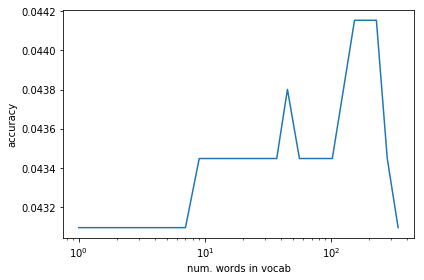

In [328]:
plt.plot(curve_data.keys(), np.divide(list(curve_data.values()), num_dev_examples))
plt.xscale('log')
plt.xlabel('num. words in vocab')
plt.ylabel('accuracy')
plt.savefig(OVERSTABILITY_CURVE_FILE, format='eps')
plt.tight_layout()
plt.show()